## Modelo 1

Se cargan las librerías.

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
import seaborn as sns
import pickle
import yaml

Se cargan los datos procesados.

In [2]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [3]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [45]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Separamos el nuevo conjunto en X e y
X_under = X_resampled
y_under = y_resampled

Se separa en train y test.

Con un GridSearch, se hiperparametriza un XGBClassifier.

In [48]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

# Definir los parámetros del GridSearchCV para XGBoost
xgb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(7, 8),
    'classifier__min_child_weight': np.arange(1, 6),
    'classifier__gamma': [0, 0.5, 1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 2, 5, 100]
}

# Crear el GridSearchCV para XGBoost
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="precision")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__gamma': [0, 0.5, 1],
                         'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': array([7]),
                         'classifier__min_child_weight': array([1, 2, 3, 4, 5]),
                         'classifier__scale_pos_weight': [1, 2, 5, 100],
                         'classifier__subsample': [0.6, 0.8, 1.0],
                         'selectkbest__k': array([5, 6, 7])},
             scoring='precision')

In [49]:
clf.best_params_

{'classifier__gamma': 0.5,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 7,
 'classifier__min_child_weight': 1,
 'classifier__scale_pos_weight': 1,
 'classifier__subsample': 0.8,
 'selectkbest__k': 6}

In [50]:
predictions = clf.predict(X_test)

[[125502   3415]
 [    16    735]]


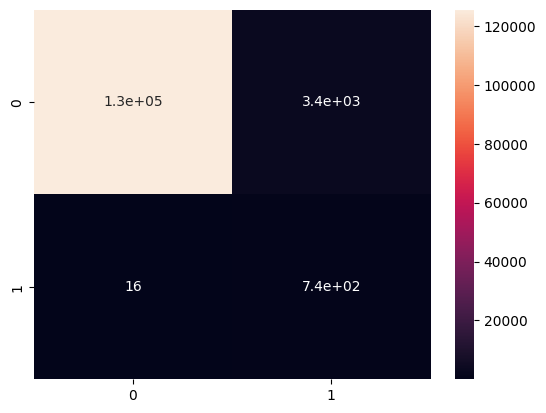

In [51]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [52]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [53]:
precision_score(y_test, predictions)

0.17710843373493976

In [54]:
recall_score(y_test, predictions)

0.9786950732356857

In [55]:
roc_auc_score(y_test, predictions)

0.9761025805608449

In [63]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'selectkbest__k': np.arange(2, 8),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(2, 10),
    'classifier__min_child_weight': np.arange(1, 6),
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="precision")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'classifier__min_child_weight': array([1, 2, 3, 4, 5]),
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7])},
             scoring='precision')

In [64]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 8,
 'classifier__min_child_weight': 1,
 'selectkbest__k': 3}

[[125494   3423]
 [    20    731]]


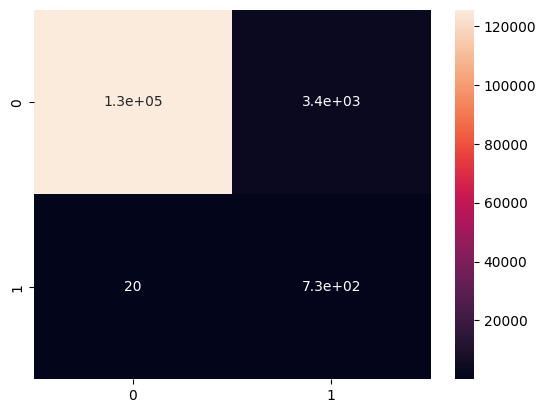

In [65]:
predictions = clf.predict(X_test)
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [66]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.1759749638902263
Recall score: 0.9733688415446072
ROC AUC score: 0.9734084369997987


In [67]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'selectkbest__k': np.arange(5, 9),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(25, 30),
    'classifier__min_child_weight': [1, 0.1, 0.01],
    'classifier__scale_pos_weight': [1, 0.1, 0.001]
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': array([25, 26, 27, 28, 29]),
                         'classifier__min_child_weight': [1, 0.1, 0.01],
                         'classifier__scale_pos_weight': [1, 0.1, 0.001],
                         'selectkbest__k': array([5, 6, 7, 8])},
             scoring='roc_auc')

In [68]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 26,
 'classifier__min_child_weight': 0.1,
 'classifier__scale_pos_weight': 1,
 'selectkbest__k': 5}

[[125265   3652]
 [    17    734]]


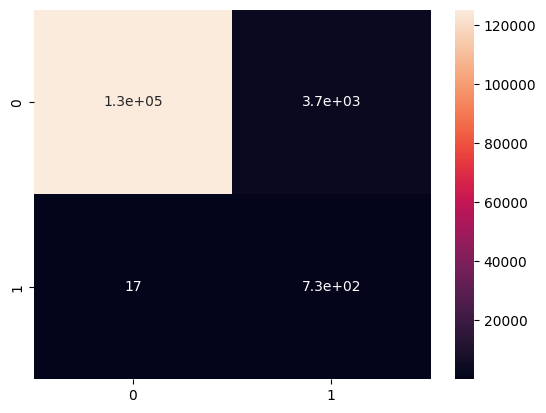

In [69]:
predictions = clf.predict(X_test)
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [70]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.16735066119471045
Recall score: 0.9773635153129161
ROC AUC score: 0.9745176055275689


In [78]:
# Define las proporciones deseadas para cada clase
sampling_strategy = {
    0: int(0.025 * len(y_train)),
    1: int(0.3 * len(y_train)) if int(0.3 * len(y_train)) <= sum(y_train == 1) else sum(y_train == 1)
}

rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
# Volvemos a separar en test y train para que el test original y los datos del undersample no contaminen a examinar
# X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(X_under,
#                                                    y_under,
#                                                    test_size = 0.2,
#                                                    random_state=0)

In [90]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'selectkbest__k': np.arange(5, 9),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(10, 18),
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17]),
                         'selectkbest__k': array([5, 6, 7, 8])},
             scoring='roc_auc')

In [91]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 11,
 'selectkbest__k': 6}

[[127536   1381]
 [    47    704]]


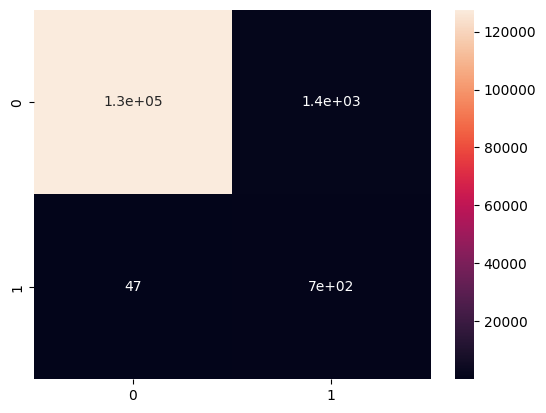

In [92]:
predictions = clf.predict(X_test)
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [93]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.3376498800959233
Recall score: 0.9374167776298269
ROC AUC score: 0.9633522294255389


In [9]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'selectkbest__k': np.arange(5, 9),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(10,11),
    'classifier__max_delta_step': [2,5,10]
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5
[CV 1/3; 1/24] END classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5;, score=0.997 total time=  28.5s
[CV 2/3; 1/24] START classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5
[CV 2/3; 1/24] END classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5;, score=0.995 total time=  31.4s
[CV 3/3; 1/24] START classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5
[CV 3/3; 1/24] END classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__max_depth=10, selectkbest__k=5;, score=0.997 total time=  27.9s
[CV 1/3; 2/24] START classifier__learning_rate=0.1, classifier__max_delta_step=2, classifier__ma

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_delta_step': [2, 5, 10],
                         'classifier__max_depth': array([10]),
                         'selectkbest__k': array([5, 6, 7, 8])},
             scoring='roc_auc', verbose=10)

In [10]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_delta_step': 5,
 'classifier__max_depth': 10,
 'selectkbest__k': 6}

[[128868     49]
 [   179    572]]
Precision score: 0.9210950080515298
Recall score: 0.7616511318242344
ROC AUC score: 0.8806355211546375


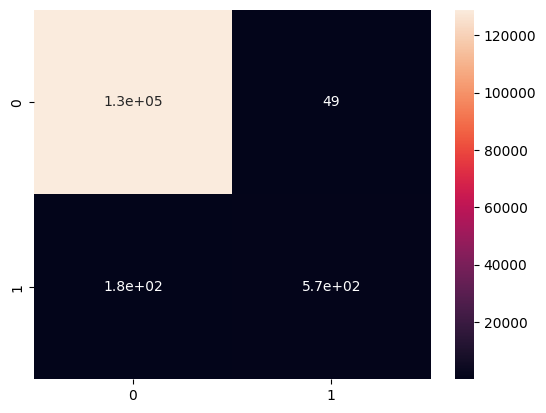

In [11]:
predictions = clf.predict(X_test)
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

In [12]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(10,11),
    'classifier__max_delta_step': [4,5,6]
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5
[CV 1/3; 1/18] END classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5;, score=0.997 total time=  37.4s
[CV 2/3; 1/18] START classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5
[CV 2/3; 1/18] END classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5;, score=0.995 total time=  36.8s
[CV 3/3; 1/18] START classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5
[CV 3/3; 1/18] END classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__max_depth=10, selectkbest__k=5;, score=0.997 total time=  31.5s
[CV 1/3; 2/18] START classifier__learning_rate=0.1, classifier__max_delta_step=4, classifier__ma

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=Non...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_delta_step': [4, 5, 6],
                         'classifier__max_depth': array([10]),
                         'selectkbest__k': array([5, 6, 7])},
             scoring='roc_auc', verbose=10)

In [13]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_delta_step': 5,
 'classifier__max_depth': 10,
 'selectkbest__k': 6}

In [25]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest(k=6)),
    ("classifier", XGBClassifier())
])

xgb_params = {
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [10],
    'classifier__max_delta_step': [5]
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=xgb_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10
[CV 1/3; 1/1] END classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10;, score=0.997 total time=  19.5s
[CV 2/3; 1/1] START classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10
[CV 2/3; 1/1] END classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10;, score=0.996 total time=  18.9s
[CV 3/3; 1/1] START classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10
[CV 3/3; 1/1] END classifier__learning_rate=0.1, classifier__max_delta_step=5, classifier__max_depth=10;, score=0.997 total time=  21.0s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest(k=6)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1],
                         'classifier__max_delta_step': [5],
                         'classifier__max_depth': [10]},
             scoring='roc_auc', verbose=10)

[[9.99619910e-01 3.80089515e-04]
 [2.38348868e-01 7.61651132e-01]]
Precision score: 0.9210950080515298
Recall score: 0.7616511318242344
ROC AUC score: 0.8806355211546375


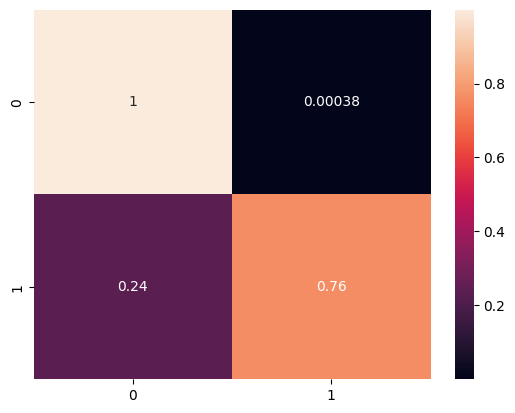

In [26]:
predictions = clf.predict(X_test)
c_matrix = confusion_matrix(y_test, predictions, normalize="true")
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

In [27]:
best_estimator = clf.best_estimator_
xgb_classifier = best_estimator.named_steps['classifier']
feature_importances = xgb_classifier.feature_importances_
print(feature_importances)

[0.22720541 0.03696065 0.37634012 0.04787361 0.285371   0.02624927]


In [29]:
select_k_best = best_estimator.named_steps['selectkbest']
selected_features = select_k_best.get_support()
feature_names = X.columns # Reemplaza X con el nombre de tu conjunto de datos de características

# Obtener los nombres de las características seleccionadas
selected_feature_names = [feature_names[i] for i, selected in enumerate(selected_features) if selected]

print(selected_feature_names)

['amt', 'city_pop', 'fraudes_por_Categoria', 'fraudes_por_edad', 'fraudes_por_hora', 'fraudes_por_día']


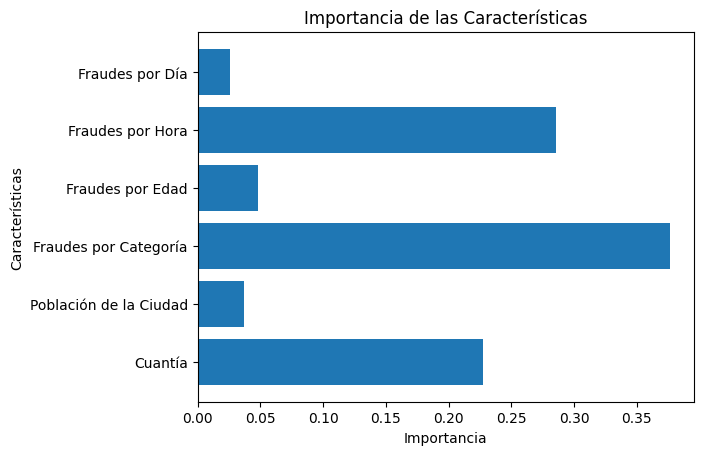

In [31]:
import matplotlib.pyplot as plt

# Definir los nombres de las características en español
feature_names_es = ['Cuantía', 'Población de la Ciudad', 'Fraudes por Categoría', 'Fraudes por Edad', 'Fraudes por Hora', 'Fraudes por Día']

# Obtener los valores de importancia de las características
importances = [0.22720541, 0.03696065, 0.37634012, 0.04787361, 0.285371, 0.02624927]

# Crear la gráfica de barras
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names_es)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')

# Mostrar la gráfica
plt.show()

Este es el mejor modelo obtenido.

In [33]:
# Para escribir el archivo pickle
with open('../models/Model4/trained_model.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model4/model_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)